In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import numpy as np
from scipy.interpolate import interp1d
from dtaidistance import dtw
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [1]:
# Load AIS data
ais_data = pd.read_csv('AIS_datapoints_ClippedTo_LongIsland.csv')

# Convert timestamps to datetime
ais_data["BaseDateTime"] = pd.to_datetime(ais_data["BaseDateTime"])

# Sort data by vessel (MMSI) and time
ais_data = ais_data.sort_values(by=["MMSI", "BaseDateTime"])

In [2]:
def segment_trajectory(group, sog_threshold=2.0, cog_threshold=15.0):
    """
    Splits a vessel trajectory into segments based on speed (SOG) and course (COG) changes.
    - sog_threshold: Minimum speed change (in knots) to start a new segment.
    - cog_threshold: Minimum course change (in degrees) to start a new segment.
    """
    group = group.sort_values("BaseDateTime").reset_index(drop=True)
    segments = []
    current_segment = [group.iloc[0]]

    for i in range(1, len(group)):
        sog_change = abs(group.iloc[i]["SOG"] - group.iloc[i-1]["SOG"])
        cog_change = abs(group.iloc[i]["COG"] - group.iloc[i-1]["COG"])

        if sog_change > sog_threshold or cog_change > cog_threshold:
            segments.append(current_segment)
            current_segment = []  # Start a new segment

        current_segment.append(group.iloc[i])

    if current_segment:
        segments.append(current_segment)

    return segments

In [3]:
# Group by MMSI (each vessel)
vessel_segments = {}

for mmsi, group in ais_data.groupby("MMSI"):
    vessel_segments[mmsi] = segment_trajectory(group)

# Count the number of segments for each vessel
num_segments_per_vessel = {mmsi: len(segments) for mmsi, segments in vessel_segments.items()}

print(f"Segmented {len(vessel_segments)} vessels into {sum(num_segments_per_vessel.values())} total segments.")


Segmented 136 vessels into 8830 total segments.


In [4]:
def compute_features(segment):
    """
    Extracts movement, geospatial, and temporal features from a trajectory segment.
    """
    segment_df = pd.DataFrame(segment)  # Convert list of dictionaries to DataFrame
    segment_df = segment_df.sort_values("BaseDateTime").reset_index(drop=True)

    # Compute basic movement features
    avg_sog = segment_df["SOG"].mean()
    avg_cog = segment_df["COG"].mean()

    # Compute total distance traveled (sum of geodesic distances)
    total_distance = sum(
        geodesic((segment_df.iloc[i-1]["LAT"], segment_df.iloc[i-1]["LON"]),
                 (segment_df.iloc[i]["LAT"], segment_df.iloc[i]["LON"])).nautical
        for i in range(1, len(segment_df))
    )

    # Compute duration (time difference between first and last point)
    duration = (segment_df["BaseDateTime"].iloc[-1] - segment_df["BaseDateTime"].iloc[0]).total_seconds() / 60  # Minutes

    # Compute MBR (bounding box)
    min_lat, max_lat = segment_df["LAT"].min(), segment_df["LAT"].max()
    min_lon, max_lon = segment_df["LON"].min(), segment_df["LON"].max()
    mbr_area = (max_lat - min_lat) * (max_lon - min_lon)  # Rough area of MBR

    # Compute trajectory complexity (ratio of actual distance to MBR diagonal)
    mbr_diagonal = geodesic((min_lat, min_lon), (max_lat, max_lon)).nautical
    trajectory_complexity = total_distance / mbr_diagonal if mbr_diagonal > 0 else 1  # Complexity ratio

    return {
        "Avg_SOG": avg_sog,
        "Avg_COG": avg_cog,
        "Total_Distance": total_distance,
        "Duration": duration,
        "MBR_Area": mbr_area,
        "Complexity": trajectory_complexity
    }


In [5]:
segment_features = []

for mmsi, segments in vessel_segments.items():
    for segment in segments:
        features = compute_features(segment)
        features["MMSI"] = mmsi  # Retain vessel ID
        segment_features.append(features)

# Convert to DataFrame for clustering
feature_df = pd.DataFrame(segment_features)

# Display extracted features
from IPython.display import display
display(feature_df)


,Avg_SOG,Avg_COG,Total_Distance,Duration,MBR_Area,Complexity,MMSI
0,3.031250,299.206250,0.897577,17.633333,1.222008e-04,1.000727,215158000
1,0.600000,322.500000,0.000000,0.000000,0.000000e+00,1.000000,215158000
2,0.500000,19.800000,0.000000,0.000000,0.000000e+00,1.000000,215158000
3,0.566667,45.900000,0.024926,2.633333,1.120000e-07,1.003395,215158000
4,0.625000,71.887500,0.089950,8.166667,9.200000e-07,1.006155,215158000
...,...,...,...,...,...,...,...
8825,4.837500,88.475000,3.739214,49.083333,1.784112e-04,1.000125,941218324
8826,4.900000,102.800000,0.000000,0.000000,0.000000e+00,1.000000,941218324
8827,4.900000,90.000000,1.175338,15.383333,1.620990e-05,1.000033,941218324
8828,4.900000,93.200000,0.469851,6.166667,3.803600e-06,1.000006,941218324


In [6]:
def resample_trajectory(lat_lon_seq, num_points=50):
    """
    Resamples a trajectory to have a fixed number of points.
    """
    lat_lon_seq = np.array(lat_lon_seq)
    if len(lat_lon_seq) < 2:
        return lat_lon_seq  # Skip very short trajectories

    t_original = np.linspace(0, 1, len(lat_lon_seq))
    t_resampled = np.linspace(0, 1, num_points)

    # Interpolate latitude and longitude separately
    lat_interp = interp1d(t_original, lat_lon_seq[:, 0], kind='linear')
    lon_interp = interp1d(t_original, lat_lon_seq[:, 1], kind='linear')

    resampled_traj = np.column_stack((lat_interp(t_resampled), lon_interp(t_resampled)))
    return resampled_traj

# Extract trajectories for each vessel
vessel_trajectories = ais_data.groupby("MMSI").apply(lambda group: list(zip(group["LAT"], group["LON"])))

# Resample all trajectories to a fixed number of points
vessel_trajectories_resampled = {mmsi: resample_trajectory(traj) for mmsi, traj in vessel_trajectories.items()}

print("Vessel trajectories resampled successfully!")


Vessel trajectories resampled successfully!


C:\Users\Carson\AppData\Local\Temp\ipykernel_25624\226867293.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vessel_trajectories = ais_data.groupby("MMSI").apply(lambda group: list(zip(group["LAT"], group["LON"])))


In [7]:
print(f"Number of resampled vessel trajectories: {len(vessel_trajectories_resampled)}")
print(f"Example trajectory (first 5 points): {list(vessel_trajectories_resampled.values())[0][:5]}")

Number of resampled vessel trajectories: 136
Example trajectory (first 5 points): [[ 40.48799    -73.53654   ]
 [ 40.49454367 -73.55248204]
 [ 40.49632143 -73.55194102]
 [ 40.49707796 -73.55046265]
 [ 40.49733633 -73.55041   ]]


In [8]:
# Convert features to numpy arrays for DTW
trajectory_list = list(vessel_trajectories_resampled.values())
num_trajectories = len(trajectory_list)

# Initialize DTW distance matrix
dtw_distance_matrix = np.zeros((num_trajectories, num_trajectories))

# Compute pairwise DTW distances
for i in range(num_trajectories):
    for j in range(i + 1, num_trajectories):  # Compute only upper triangle
        dtw_distance = dtw.distance(trajectory_list[i][:, 0], trajectory_list[j][:, 0])  # Using only latitude
        dtw_distance_matrix[i, j] = dtw_distance
        dtw_distance_matrix[j, i] = dtw_distance  # Symmetric matrix

print("DTW Distance Matrix Computed.")


DTW Distance Matrix Computed.


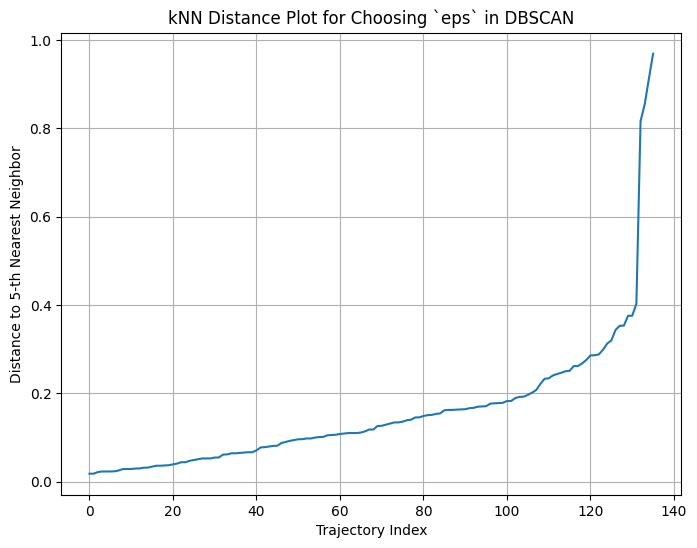

In [9]:
# Find optimal epsilon using kNN distances
k = 5  # Use min_samples as k
nbrs = NearestNeighbors(n_neighbors=k, metric="precomputed").fit(dtw_distance_matrix)
distances, indices = nbrs.kneighbors(dtw_distance_matrix)

# Sort k-th nearest distances and plot
sorted_distances = np.sort(distances[:, -1])
plt.figure(figsize=(8, 6))
plt.plot(sorted_distances)
plt.xlabel("Trajectory Index")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.title("kNN Distance Plot for Choosing `eps` in DBSCAN")
plt.grid()
plt.show()


In [10]:
# Set `eps` based on kNN plot
#optimal_eps = 1.1 * np.percentile(sorted_distances, 5)  # Adjust based on elbow point

# Apply DBSCAN with precomputed DTW distance matrix
dbscan = DBSCAN(eps=0.3, min_samples=10, metric="precomputed")  # Adjust `min_samples`
labels = dbscan.fit_predict(dtw_distance_matrix)

# Store clustering results
cluster_results = pd.DataFrame({"MMSI": list(vessel_trajectories_resampled.keys()), "Cluster": labels})
print(cluster_results.head())


        MMSI  Cluster
0  215158000        0
1  219382000        1
2  232012788        0
3  241659000        0
4  244780813        0


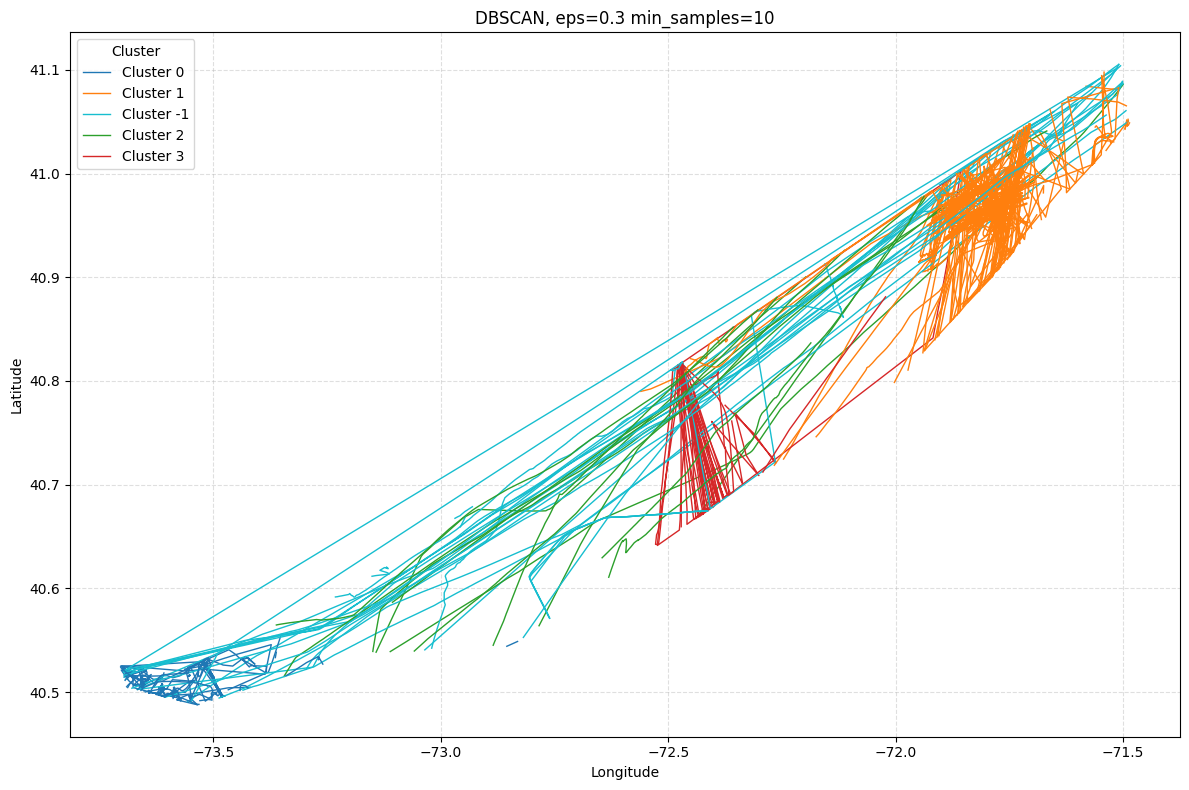

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure
plt.figure(figsize=(12, 8))

# Plot each trajectory as a line colored by cluster
for mmsi, traj in vessel_trajectories.items():
    cluster_label = cluster_results.loc[cluster_results["MMSI"] == mmsi, "Cluster"].values[0]
    latitudes, longitudes = zip(*traj)

    plt.plot(longitudes, latitudes, label=f"Cluster {cluster_label}", 
             color=sns.color_palette("tab10")[cluster_label % 10], 
             linewidth=1)

# Optional: only show unique cluster labels once in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Cluster", loc='upper left')

# Add grid and labels
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN, eps=0.3 min_samples=10")

plt.tight_layout()
plt.show()


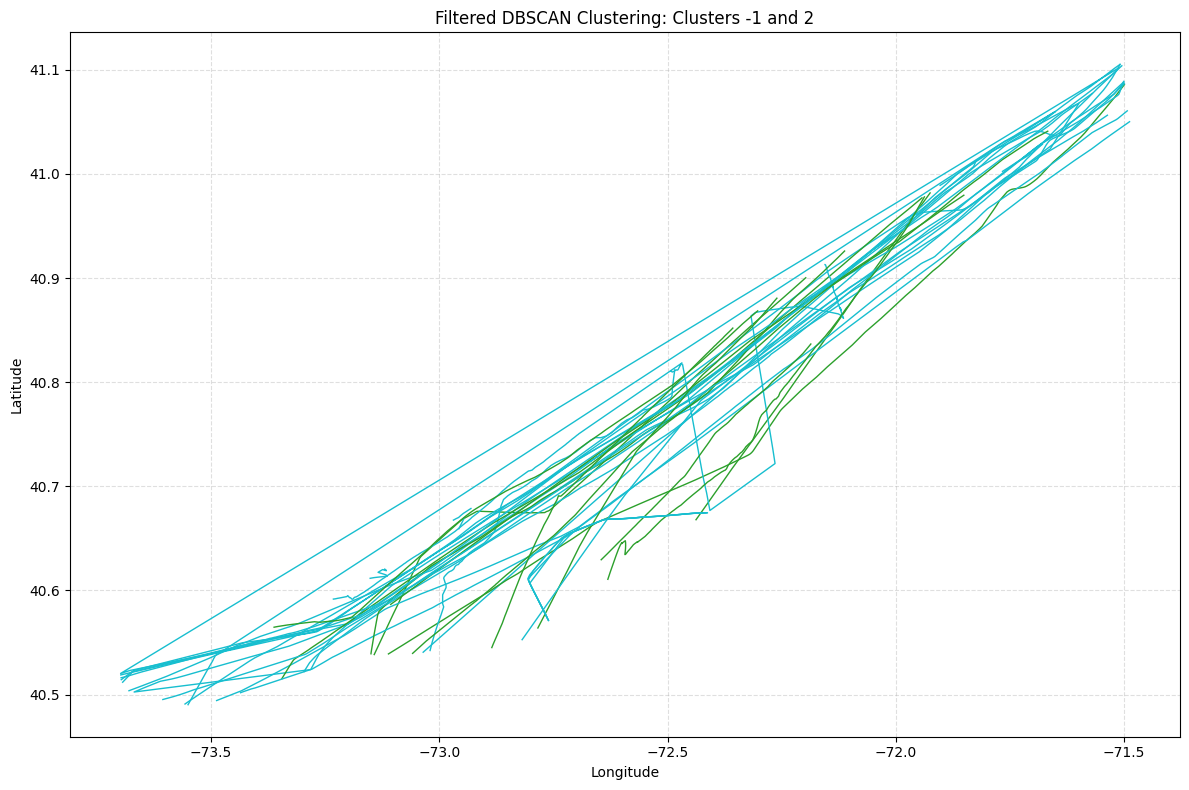

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure
plt.figure(figsize=(12, 8))

# Plot only clusters -1 and 2
for mmsi, traj in vessel_trajectories.items():
    cluster_label = cluster_results.loc[cluster_results["MMSI"] == mmsi, "Cluster"].values[0]

    if cluster_label not in [-1, 2]:
        continue  # Skip other clusters

    latitudes, longitudes = zip(*traj)
    
    plt.plot(
        longitudes, latitudes, 
        label=f"Cluster {cluster_label}", 
        color=sns.color_palette("tab10")[cluster_label % 10], 
        linewidth=1
    )

# Clean up legend to only show each cluster once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys(), title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot formatting
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Filtered DBSCAN Clustering: Clusters -1 and 2")
plt.tight_layout()
plt.show()


In [13]:
# Count all DBSCAN tracks
total_tracks = len(vessel_trajectories)

# Get MMSI values for clusters -1 and 2
selected_mmsi = cluster_results[cluster_results["Cluster"].isin([-1, 2])]["MMSI"].unique()

# Count tracks in clusters -1 and 2
filtered_tracks = sum(1 for mmsi in selected_mmsi if mmsi in vessel_trajectories)

# Display results
print(f"Starting Tracks: {total_tracks}")
print(f"Filtered Tracks: {filtered_tracks}")
print(f"Percentage: {filtered_tracks / total_tracks:.2%}")



Starting Tracks: 136
Filtered Tracks: 35
Percentage: 25.74%
